# KNN Regression

In [1]:
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score,KFold
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

## Load and clean DataFrame 
- Predict log of number of followers for each playlist. 
- Standardize columns to be between 0 and 1. 
- Take 80/20 test/train split
- Create interaction terms for loudness and danceability
- Remove playlists that have zero followers 

In [2]:
data = pd.read_csv('df_by_playlist.csv',index_col=0)
data = data.loc[data['followers'] > 0]
y = np.log(data['followers'].values)
y = y.reshape(len(y),1)
names = list(data)
names.remove('followers')

Functions to create cross-terms for quantitative predictors and plot KNN results

In [3]:
quant_predictors = list([predictor for predictor in names if data.loc[:,predictor].unique().sum()!=1])

def interact(x,variable,predictors=quant_predictors):
    for predictor in predictors:
        x[variable+'_'+predictor] = x[variable]*x[predictor]
    return x

def plot_knn(knn_train_scores,knn_test_scores,best_k,title_ = ''):
    plt.plot(ks,knn_train_scores,label = 'Training score')
    plt.plot(ks,knn_test_scores,label = 'Testing score')
    plt.xlabel('K nearest neighbors')
    plt.ylabel('R^2 Score')
    plt.title('KNN Regression {}, Best k = {}'.format(title_,best_k))
    plt.legend()
    plt.show()

## KNN Regression
- Begin with baseline KNN using all attributes, including genres, to predict followers in a playlist 
- Next use a se
- Finally, use a subset of predictors with interaction terms 
- Use cross-validation for the training and testing sets 
- We will use the $R^2$ score of the testing set as the determination of the best model 

### Regression with all predictors 

KNN Logistic Regression Training Score k = 19: 0.13458202407748732
KNN Logistic Regression Testing Score k = 19: 0.045064716969836126



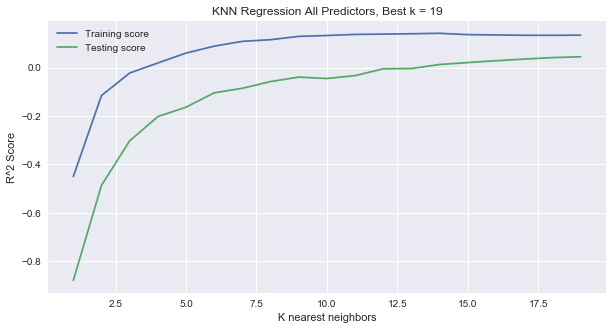

In [4]:
X = data.copy()

# normalize and split 
X = (X - X.min()) / (X.max() - X.min())
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,random_state = 29)

all_train_scores, all_test_scores = [],[]
ks = np.arange(1,20)

for k in ks:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(xtrain,ytrain)
    kf = KFold(n_splits=3,random_state=29)
    train_scores = cross_val_score(knn,xtrain,ytrain,scoring="r2", cv=kf)
    test_scores = cross_val_score(knn,xtest,ytest,scoring="r2", cv=kf)
    all_train_scores.append(np.mean(train_scores))
    all_test_scores.append(np.mean(test_scores))

k_arg = np.argmax(all_test_scores)
best_k = ks[k_arg]
print('KNN Logistic Regression Training Score k = {}: {}'.
       format(best_k,all_train_scores[k_arg]))
print('KNN Logistic Regression Testing Score k = {}: {}\n'.
       format(best_k,all_test_scores[k_arg]))
plot_knn(all_train_scores,all_test_scores,best_k,'All Predictors')

Including all columns gives a what looks like a poor $R^2$ score. We suspect our one-hot encoded columns for genre and key/time signature are not helping the regression. To test this, include only quantitative predictors for our next regression.

KNN Logistic Regression Training Score k = 9: 0.187927317650748
KNN Logistic Regression Testing Score k = 9: 0.23302829697387395



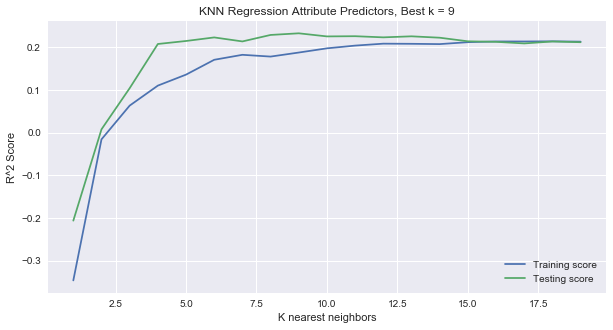

In [5]:
cols = ['acousticness','danceability','duration_ms','energy','instrumentalness','liveness',
 'loudness','popularity','speechiness','tempo','valence']
X = data[cols]

# normalize and split 
X = (X - X.min()) / (X.max() - X.min())
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,random_state = 29)

sub_train_scores, sub_test_scores = [],[]
ks = np.arange(1,20)

for k in ks:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(xtrain,ytrain)
    kf = KFold(n_splits=3,random_state=29)
    train_scores = cross_val_score(knn,xtrain,ytrain,scoring="r2", cv=kf)
    test_scores = cross_val_score(knn,xtest,ytest,scoring="r2", cv=kf)
    sub_train_scores.append(np.mean(train_scores))
    sub_test_scores.append(np.mean(test_scores))

k_arg = np.argmax(sub_test_scores)
best_k = ks[k_arg]
print('KNN Logistic Regression Training Score k = {}: {}'.
       format(best_k,sub_train_scores[k_arg]))
print('KNN Logistic Regression Testing Score k = {}: {}\n'.
       format(best_k,sub_test_scores[k_arg]))
plot_knn(sub_train_scores,sub_test_scores,best_k,'Attribute Predictors')

Using only quantitative predictors improves the testing $R^2$ substatially. To further improve our model, let's add interaction terms. 

### Interaction Terms 
- Include interaction terms with loudness and danceability 

KNN Logistic Regression Training Score k = 8: 0.3522030733672195
KNN Logistic Regression Testing Score k = 8: 0.33177549813137625



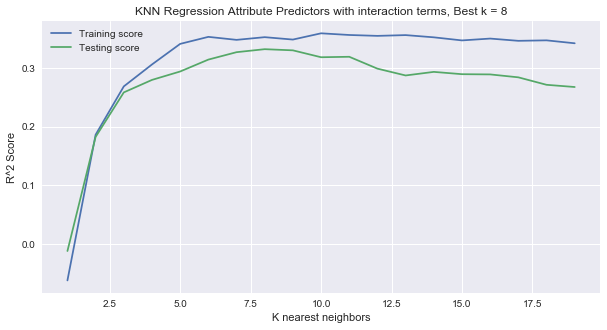

In [6]:
drop_cols = ['pop','rock','folk','mellow','indie','rap','house','r&b','stomp and holler','singer-songwriter','edm',
 'quiet storm','contemporary','christmas','funk','metal','alternative','adult standards','americana',
 'soul','blues','hip hop','motown','punk','disco','other','time_sign_0.0','time_sign_3.0','time_sign_4.0',
 'key_0.0','key_1.0','key_2.0','key_3.0','key_4.0','key_5.0','key_6.0','key_7.0','key_8.0','key_9.0','key_10.0',
 'key_11.0','track_feat','track_remast','track_remix','album_feat', 'album_deluxe','album_best','followers']

X = data.drop(drop_cols,1)
X = interact(X,'loudness')
X = interact(X,'danceability',list(['speechiness','tempo']))

# normalize and split 
X = (X - X.min()) / (X.max() - X.min())
xtrain, xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,random_state = 29)

# split 
int_train_scores, int_test_scores = [],[]
ks = np.arange(1,20)

for k in ks:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(xtrain,ytrain)
    kf = KFold(n_splits=3,random_state=29)
    train_scores = cross_val_score(knn,xtrain,ytrain,scoring="r2", cv=kf)
    test_scores = cross_val_score(knn,xtest,ytest,scoring="r2", cv=kf)
    int_train_scores.append(np.mean(train_scores))
    int_test_scores.append(np.mean(test_scores))

k_arg = np.argmax(int_test_scores)
best_k = ks[k_arg]
print('KNN Logistic Regression Training Score k = {}: {}'.
       format(best_k,int_train_scores[k_arg]))
print('KNN Logistic Regression Testing Score k = {}: {}\n'.
       format(best_k,int_test_scores[k_arg]))
plot_knn(int_train_scores,int_test_scores,best_k,'Attribute Predictors with interaction terms')

By adding interaction terms, our testing $R^2$ score improves from 0.23 to 0.33.
Finally, we'll look at the residuals in our prections. 

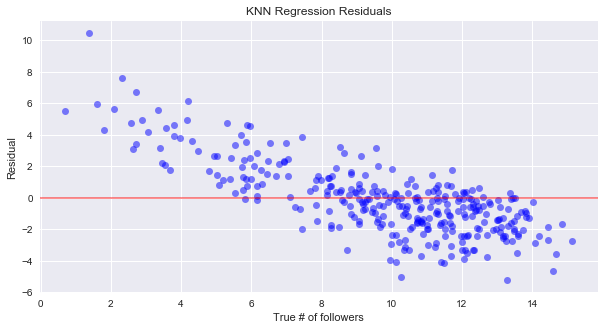

In [7]:
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(xtrain,ytrain)
plt.plot(ytest,knn.predict(xtest) - ytest,'bo',alpha = 0.5)
plt.axhline(0,color = 'r',alpha = 0.5)
plt.xlabel('True # of followers')
plt.ylabel('Residual')
plt.title('KNN Regression Residuals')
plt.savefig('KNN_RESIDUAL.png')
plt.show()

The model is overpredicting the number of followers for playlists with a small number of followers and underpredicting on playlists with a high number of followers. 

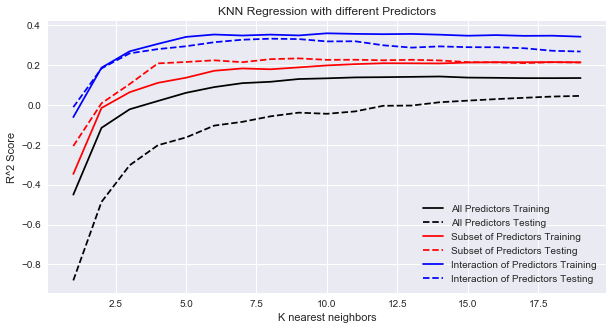

In [8]:
# plot all training and testing scores 

plt.plot(ks,all_train_scores,'k-',label = 'All Predictors Training')
plt.plot(ks,all_test_scores,'k--',label = 'All Predictors Testing')
plt.plot(ks,sub_train_scores,'r-',label = 'Subset of Predictors Training')
plt.plot(ks,sub_test_scores,'r--',label = 'Subset of Predictors Testing')
plt.plot(ks,int_train_scores,'b-',label = 'Interaction of Predictors Training')
plt.plot(ks,int_test_scores,'b--',label = 'Interaction of Predictors Testing')
plt.xlabel('K nearest neighbors')
plt.ylabel('R^2 Score')
plt.title('KNN Regression with different Predictors')
plt.legend()
plt.savefig('KNN_REGRESSION.png')
plt.show()